# Evaluate VAE Model
This notebook conducts a qualitative analysis of the best VAE configuration found via the random search conducted in `keras_vae_sweep.py`.

The reconstruction error, aswell as the latent space are plotted.

In [5]:
config = {
    "train_test_split": 0.95,
    "random_state": 1,
    "loss": "msle",
    "optimizer": "adam",
    "epochs": 50,
    "batch_size": 1712,
    "architecture": [8, 7, 5],
    "activation": "softmax",
    "latent_dimension": 4,
    "learning_rate": 0.01,
    "kl_weighting": 1.3,
    "features": [
        "std_rush_order",
        "avg_rush_order",
        "std_trades",
        "std_volume",
        "avg_volume",
        "std_price",
        "avg_price",
        "avg_price_max",
    ],
}

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import (
    f1_score,
    recall_score,
    confusion_matrix,
    accuracy_score,
    precision_score,
)
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def create_datasets():
    time_freq = "15S"
    computed_data = pd.read_csv(
        "../../data/la_morgia_data/features_" + time_freq + ".csv.gz",
        parse_dates=["date"],
    )

    normal_datapoints = computed_data[computed_data["gt"] == 0]
    anomaly_datapoints = computed_data[computed_data["gt"] == 1]

    train_set = normal_datapoints.sample(frac=0.95, random_state=1)

    test_set_normal = normal_datapoints.drop(train_set.index)
    test_sets = [test_set_normal, anomaly_datapoints]
    test_set = pd.concat(test_sets)

    features = [
        "std_rush_order",
        "avg_rush_order",
        "std_trades",
        "std_volume",
        "avg_volume",
        "std_price",
        "avg_price",
        "avg_price_max",
        # "hour_sin",
        # "hour_cos",
        # "minute_sin",
        # "minute_cos",
    ]

    x_train = train_set[features]
    x_test = test_set[features]
    y_train = train_set["gt"]
    y_test = test_set["gt"]

    return x_train, y_train, x_test, y_test


def set_optimizer(optimizer, learning_rate):
    if optimizer == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = SGD(learning_rate=learning_rate)

    return optimizer


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def build_encoder(activation, dimensions, latent_dim=2):
    inputs = layers.Input(shape=dimensions[0], name="encoder_input")
    x = layers.Dense(dimensions[1], activation=activation)(inputs)

    if len(dimensions) == 3:
        x = layers.Dense(dimensions[2], activation=activation)(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    return encoder


def build_decoder(activation, dimensions, latent_dim=2):
    latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")

    if len(dimensions) == 3:
        x = layers.Dense(dimensions[2], activation=activation)(latent_inputs)
        x = layers.Dense(dimensions[1], activation=activation)(x)
    else:
        x = layers.Dense(dimensions[1], activation=activation)(latent_inputs)

    outputs = layers.Dense(dimensions[0])(x)

    decoder = keras.Model(latent_inputs, outputs, name="decoder")
    decoder.summary()
    return decoder


class VAE(keras.Model):
    def __init__(self, encoder, decoder, kl_weight, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = kl_weight
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        data = data[0] if isinstance(data, tuple) else data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.kl_weight * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


class LogMetricsCallback(Callback):
    def __init__(self, vae, log_frequency):
        super().__init__()
        self.vae = vae
        self.log_frequency = log_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.log_frequency == 0:
            evaluate_model(self.vae)


def evaluate_model(vae):
    error_thresh = get_error_thresh(vae)
    mae_vector, anomalies = get_anomalies(vae, error_thresh)
    log_metrics(anomalies, error_thresh)


def evaluate_model_final(vae, run_name, latent_dimension):
    error_thresh = get_error_thresh(vae)
    mae_vector, anomalies = get_anomalies(vae, error_thresh)
    log_metrics(anomalies, error_thresh)
    return vae, run_name, mae_vector, anomalies, latent_dimension, error_thresh


def train_model(config):
    encoder = build_encoder(
        config["activation"],
        config["architecture"],
        latent_dim=config["latent_dimension"],
    )
    decoder = build_decoder(
        config["activation"],
        config["architecture"],
        latent_dim=config["latent_dimension"],
    )

    vae = VAE(encoder, decoder, config["kl_weighting"])
    optimizer = set_optimizer(config["optimizer"], config["learning_rate"])
    vae.compile(optimizer=optimizer)
    vae.fit(
        x_train,
        x_train,
        epochs=config["epochs"],
        batch_size=config["batch_size"],
    )
    return vae


def get_error_thresh(vae):
    z_mean, z_log_var, z = vae.encoder.predict(x_train)
    x_train_reconstructions = vae.decoder.predict(z)

    mae_vector = np.mean(abs(x_train_reconstructions - x_train), axis=1)

    print(
        f"Avg error {np.mean(mae_vector)}\n median error {np.median(mae_vector)}\n 99Q: {np.quantile(mae_vector, 0.99)}"
    )
    print(f"setting threshold on { np.quantile(mae_vector, 0.9965)} ")

    error_thresh = np.quantile(mae_vector, 0.9965)
    return error_thresh


def get_anomalies(vae, error_thresh):
    z_mean, z_log_var, z = vae.encoder.predict(x_test)
    x_test_reconstructions = vae.decoder.predict(z)

    mae_vector = np.mean(abs(x_test_reconstructions - x_test), axis=1)
    anomalies = mae_vector > error_thresh
    return mae_vector, anomalies


def log_metrics(anomalies, error_thresh):
    predictions = anomalies
    threshold = error_thresh
    overall_score = (
        accuracy_score(y_test, predictions)
        + precision_score(y_test, predictions)
        + recall_score(y_test, predictions)
        + f1_score(y_test, predictions, average="macro")
        + f1_score(y_test, predictions, average="micro")
    )

    print(
        {
            "Accuracy": accuracy_score(y_test, predictions),
            "Precision": precision_score(y_test, predictions),
            "Recall": recall_score(y_test, predictions),
            "F1_Macro": f1_score(y_test, predictions, average="macro"),
            "F1_Micro": f1_score(y_test, predictions, average="micro"),
            "Overall_Score": overall_score,
            "Confusion Matrix": confusion_matrix(y_test, predictions),
            "threshold": threshold,
        }
    )

In [6]:
x_train, y_train, x_test, y_test = create_datasets()
vae = train_model(config)

(
    vae,
    run_name,
    mae_vector,
    anomalies,
    latent_dimension,
    error_thresh,
) = evaluate_model_final(vae, "test", config["latent_dimension"])

Config Dimensions:  [8, 7, 5]
<class 'list'>

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 8)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 7)                    63        ['encoder_input[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 5)                    40        ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 4)                    24        ['dense_1[0][0]']             
                                              

  1/923 [..............................] - ETA: 29s

923/923 [==============================] - 2s 2ms/step


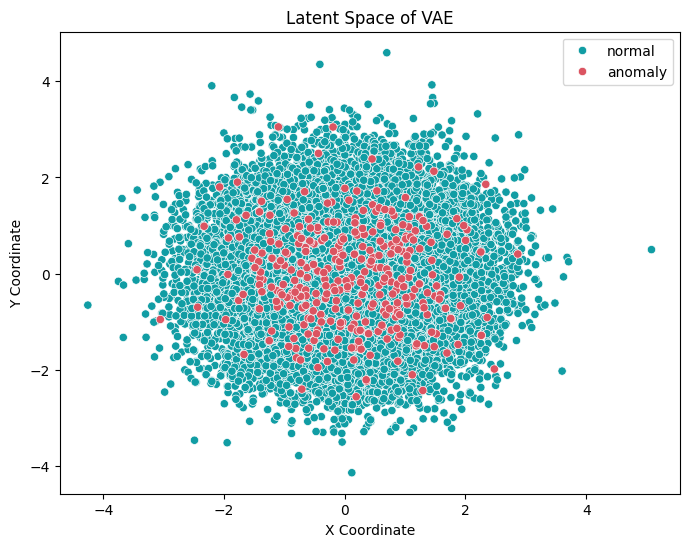

In [8]:
# plot latent space PCA
from sklearn.decomposition import PCA


z_mean, z_log_var, z = vae.encoder.predict(x_test)
pca = PCA(n_components=2)
X_transform = pca.fit_transform(z)

labels = list(y_test)
label_names = {0: "normal", 1: "anomaly"}
labels_named = np.vectorize(label_names.get)(labels)


palette_named = {"normal": "#119DA4", "anomaly": "#DB5461"}
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_transform[:, 0],
    y=X_transform[:, 1],
    hue=labels_named,
    palette=palette_named,
    legend="full",
)
plt.title("Latent Space of VAE")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

923/923 [==============================] - 2s 2ms/step


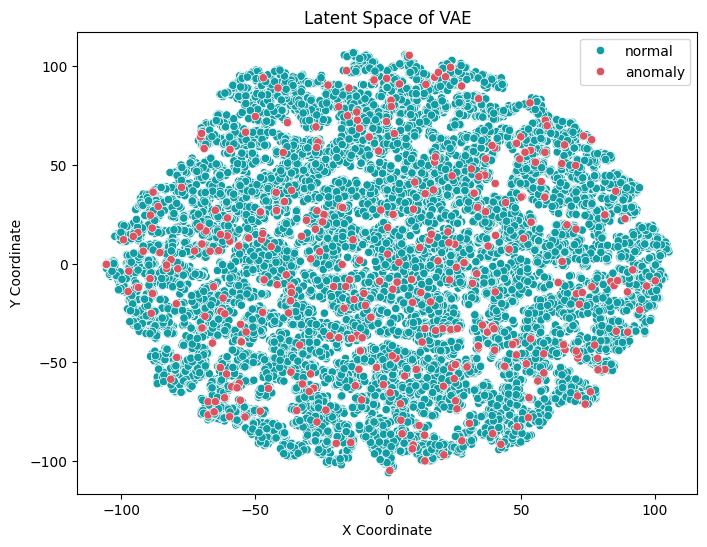

In [9]:
# plot latent space TSNE
from sklearn.manifold import TSNE


z_mean, z_log_var, z = vae.encoder.predict(x_test)
X_embbeded = TSNE(n_components=2).fit_transform(z)

labels = list(y_test)
label_names = {0: "normal", 1: "anomaly"}
labels_named = np.vectorize(label_names.get)(labels)


palette_named = {"normal": "#119DA4", "anomaly": "#DB5461"}
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_embbeded[:, 0],
    y=X_embbeded[:, 1],
    hue=labels_named,
    palette=palette_named,
    legend="full",
)
plt.title("Latent Space of VAE")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

923/923 [==============================] - 2s 2ms/step


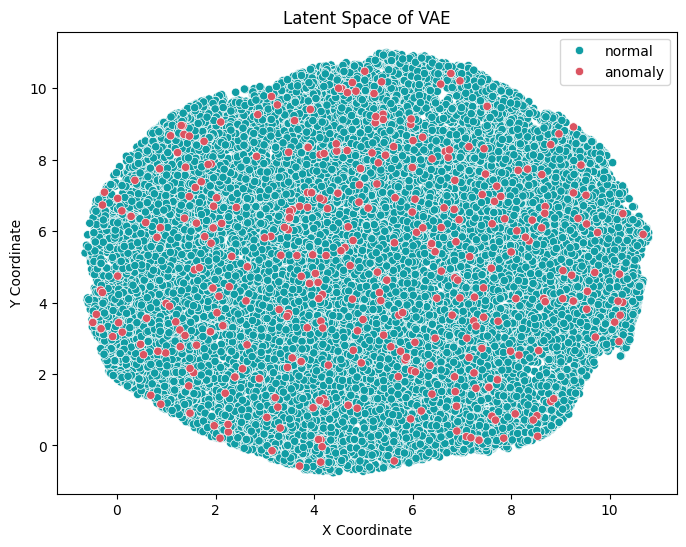

In [14]:
# plot latent space UMAP
import umap.umap_ as umap

z_mean, z_log_var, z = vae.encoder.predict(x_test)
reducer = umap.UMAP()
X_embbeded = reducer.fit_transform(z)

labels = list(y_test)
label_names = {0: "normal", 1: "anomaly"}
labels_named = np.vectorize(label_names.get)(labels)


palette_named = {"normal": "#119DA4", "anomaly": "#DB5461"}
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_embbeded[:, 0],
    y=X_embbeded[:, 1],
    hue=labels_named,
    palette=palette_named,
    legend="full",
)
plt.title("Latent Space of VAE")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

0.19072315041281376
<class 'pandas.core.series.Series'>
Highest reconstruction error: 11.331553560882806


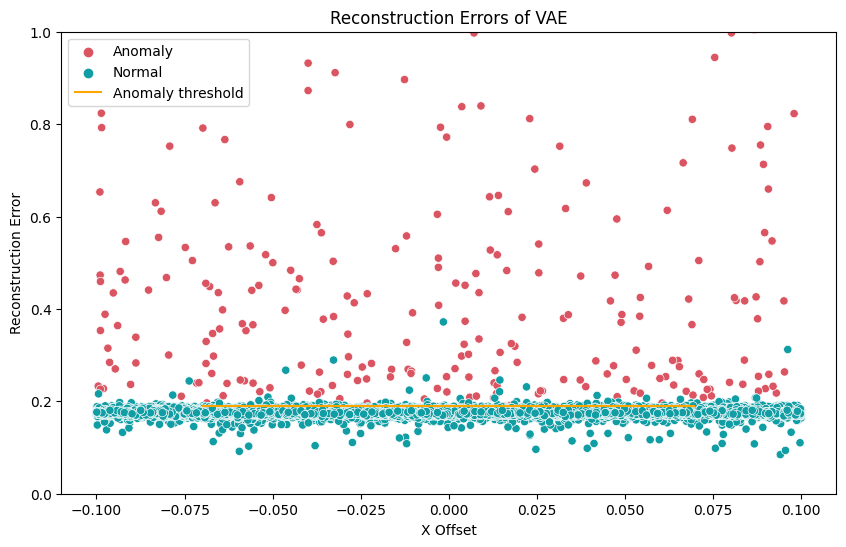

In [ ]:
# Plot Reconstruction Errors
import matplotlib.pyplot as plt

errors = tf.Variable(mae_vector).numpy().tolist()
labels = list(y_test)
offsets = np.random.uniform(-0.1, 0.1, size=len(errors))
print(f"Highest reconstruction error: {max(errors)}")

errors_df = pd.DataFrame(
    {f"reconstruction_error": errors, "x_offset": offsets, "label": labels}
)
errors_df = errors_df.sort_values(by="label", ascending=False)
errors_df["label"] = errors_df["label"].map({0: "Normal", 1: "Anomaly"})

# Creating a scatter plot
plt.figure(figsize=(10, 6))

# Plotting the data points with colors based on the label
scatter_plot = sns.scatterplot(
    data=errors_df,
    x="x_offset",
    y="reconstruction_error",
    hue="label",
    palette=["#DB5461", "#119DA4"],
    legend="brief",
)

plt.hlines(
    y=error_thresh,
    xmin=-0.07,
    xmax=0.07,
    colors="orange",
    linestyles="-",
    lw=1.5,
    label="Anomaly threshold",
)

# Setting titles and labels
plt.ylim(0, 1.0)
plt.title("Reconstruction Errors of VAE")
plt.xlabel("X Offset")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()